In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [2]:
import os
import glob
import shutil
import yaml
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import concurrent.futures

base_dir = "/content/drive/MyDrive/Project/Dataset/css-data"
image_dir = os.path.join(base_dir, "train/images")
label_dir = os.path.join(base_dir, "train/labels")
crossval_dir = os.path.join(base_dir, "cross_validation")

os.makedirs(crossval_dir, exist_ok=True)

k_folds = 5
images = sorted(glob.glob(f"{image_dir}/*.jpg") + glob.glob(f"{image_dir}/*.png"))
labels = [
    os.path.join(label_dir, os.path.basename(i).replace(".jpg", ".txt").replace(".png", ".txt"))
    for i in images
]

print(f"Found {len(images)} images and {len(labels)} label files.")
def get_major_class(label_file):
    """Returns the most frequent class ID in a label file for stratified splitting."""
    try:
        if not os.path.exists(label_file):
            return -1
        with open(label_file, "r") as f:
            lines = [line.strip().split()[0] for line in f if line.strip()]
        if not lines:
            return -1
        classes = [int(cls) for cls in lines]
        return max(set(classes), key=classes.count)
    except:
        return -1

# Use parallel processing for speed
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    y_labels = list(tqdm(executor.map(get_major_class, labels), total=len(labels), desc="Analyzing labels"))

# Filter out unlabelled or invalid entries
valid_data = [(img, lbl, y) for img, lbl, y in zip(images, labels, y_labels) if y != -1]
images, labels, y_labels = zip(*valid_data)
print(f"Valid labeled images: {len(images)}")

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(images, y_labels), start=1):
    print(f"\nPreparing Fold {fold}...")
    fold_dir = os.path.join(crossval_dir, f"fold{fold}")

    # Create directory structure
    for split in ["train", "val"]:
        os.makedirs(os.path.join(fold_dir, f"{split}/images"), exist_ok=True)
        os.makedirs(os.path.join(fold_dir, f"{split}/labels"), exist_ok=True)

    # Copy files
    for i in tqdm(train_idx, desc=f"Copying train data (Fold {fold})"):
        shutil.copy(images[i], os.path.join(fold_dir, "train/images"))
        shutil.copy(labels[i], os.path.join(fold_dir, "train/labels"))

    for i in tqdm(val_idx, desc=f"Copying val data (Fold {fold})"):
        shutil.copy(images[i], os.path.join(fold_dir, "val/images"))
        shutil.copy(labels[i], os.path.join(fold_dir, "val/labels"))

    # Create data.yaml for YOLO
    yaml_data = {
        'path': fold_dir,
        'train': 'train/images',
        'val': 'val/images',
        'names': {0: 'Helmet', 1: 'Vest', 2: 'Gloves'}
    }

    with open(os.path.join(fold_dir, "data.yaml"), 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Fold {fold} created successfully: {fold_dir}")

print("\nAll folds created and stratified successfully!")
print("Cross-validation folder:", crossval_dir)


Found 2605 images and 2605 label files.


Analyzing labels: 100%|██████████| 2605/2605 [00:15<00:00, 171.09it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Valid labeled images: 2599

Preparing Fold 1...


Copying val data (Fold 1): 100%|██████████| 520/520 [00:14<00:00, 37.10it/s]


Fold 1 created successfully: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1

Preparing Fold 2...


Copying val data (Fold 2): 100%|██████████| 520/520 [00:13<00:00, 38.42it/s]


Fold 2 created successfully: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold2

Preparing Fold 3...


Copying val data (Fold 3): 100%|██████████| 520/520 [00:13<00:00, 37.72it/s]


Fold 3 created successfully: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3

Preparing Fold 4...


Copying val data (Fold 4): 100%|██████████| 520/520 [00:13<00:00, 37.33it/s]


Fold 4 created successfully: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold4

Preparing Fold 5...


Copying val data (Fold 5): 100%|██████████| 519/519 [00:13<00:00, 37.64it/s]

Fold 5 created successfully: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold5

All folds created and stratified successfully!
Cross-validation folder: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation


In [5]:
import os

fold_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1"

train_images = os.listdir(os.path.join(fold_path, "train/images"))
train_labels = os.listdir(os.path.join(fold_path, "train/labels"))

print(f"Train Images: {len(train_images)} | Train Labels: {len(train_labels)}")

missing_labels = [img for img in train_images if not os.path.exists(os.path.join(fold_path, "train/labels", os.path.splitext(img)[0] + ".txt"))]
if missing_labels:
    print("\n⚠️ Missing label files for these images:")
    print(missing_labels[:10])
else:
    print("\n✅ All training images have corresponding labels.")


Train Images: 2079 | Train Labels: 2079

✅ All training images have corresponding labels.


In [6]:
import glob
import os

fold_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1"

def is_valid_label(path):
    try:
        with open(path, "r") as f:
            lines = [line.strip().split() for line in f if line.strip()]
            if len(lines) == 0:
                return False
            for parts in lines:
                if len(parts) != 5:  # class_id + 4 coords
                    return False
                cls, *coords = parts
                if not cls.isdigit():
                    return False
                if not all(0 <= float(x) <= 1 for x in coords):
                    return False
        return True
    except Exception:
        return False

label_dir = os.path.join(fold_path, "train/labels")
bad_labels = [lbl for lbl in glob.glob(f"{label_dir}/*.txt") if not is_valid_label(lbl)]

print(f"Total bad labels: {len(bad_labels)}")
if bad_labels:
    print("⚠️ Example bad files:")
    print(bad_labels[:10])


Total bad labels: 0


In [7]:
data_yaml = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/data.yaml"

with open(data_yaml, 'r') as f:
    print(f.read())


names:
  0: Helmet
  1: Vest
  2: Gloves
path: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1
train: train/images
val: val/images



In [8]:
import yaml
import os

# Paths
original_yaml = "/content/drive/MyDrive/Project/Dataset/css-data/data.yaml"
crossval_base = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"

# Load original YAML (source of truth)
with open(original_yaml, "r") as f:
    original_cfg = yaml.safe_load(f)

# Update each fold YAML
for k in range(1, 6):  # for fold1 to fold5
    fold_yaml = os.path.join(crossval_base, f"fold{k}", "data.yaml")
    if not os.path.exists(fold_yaml):
        print(f"⚠️ Skipping {fold_yaml} (not found)")
        continue

    # Create new YAML config for the fold
    new_cfg = {
        "path": f"/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold{k}",
        "train": "train/images",
        "val": "val/images",
        "names": original_cfg["names"],  # Copy class names from original
    }

    # Write updated YAML
    with open(fold_yaml, "w") as f:
        yaml.dump(new_cfg, f, sort_keys=False)

    print(f"✅ Updated {fold_yaml}")

print("\n🎯 All fold YAMLs updated successfully!")


✅ Updated /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/data.yaml
✅ Updated /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold2/data.yaml
✅ Updated /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3/data.yaml
✅ Updated /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold4/data.yaml
✅ Updated /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold5/data.yaml

🎯 All fold YAMLs updated successfully!


In [13]:
!ls -d /content/drive/MyDrive/Project/Dataset/css-data


/content/drive/MyDrive/Project/Dataset/css-data


In [15]:
!ls -R /content/drive/MyDrive/Project/Dataset/css-data | head -n 40


/content/drive/MyDrive/Project/Dataset/css-data:
cross_validation
data.yaml
README.dataset.txt
README.roboflow.txt
test
train
valid

/content/drive/MyDrive/Project/Dataset/css-data/cross_validation:
fold1
fold2
fold3
fold4
fold5
results_fold1

/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1:
data.yaml
train
val

/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/train:
images
labels
labels.cache

/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/train/images:
000415_jpg.rf.63b7e0293fb53612fdb4695fa0debfb7.jpg
000415_jpg.rf.6b9ff926deef3b67d6cb46c8bd2b2366.jpg
000415_jpg.rf.6e1ef08de110baace091eb9f5b5867a2.jpg
000415_jpg.rf.8b898a9652182d324999f62f39119cfb.jpg
000415_jpg.rf.c62308395a66d63dfabcd495662a22e6.jpg
001425_jpg.rf.02937146b9b48ec81a3c3cf7f0d4d50e.jpg
001425_jpg.rf.85bc2e1d337adb66e78e393c2aecff1c.jpg
001425_jpg.rf.970cbc9921e627d49bab629e2bc7dd6c.jpg
002458_jpg.rf.2d87971bcbefb5465fabce9ab5ec5967.jpg
002458_jpg.rf

In [16]:
import os
from glob import glob

def verify_fold(fold_path):
    img_dir = os.path.join(fold_path, "train/images")
    lbl_dir = os.path.join(fold_path, "train/labels")
    val_img_dir = os.path.join(fold_path, "val/images")
    val_lbl_dir = os.path.join(fold_path, "val/labels")

    train_imgs = glob(f"{img_dir}/*.jpg") + glob(f"{img_dir}/*.png")
    val_imgs = glob(f"{val_img_dir}/*.jpg") + glob(f"{val_img_dir}/*.png")

    train_labels = [os.path.join(lbl_dir, os.path.basename(i).rsplit('.',1)[0] + ".txt") for i in train_imgs]
    val_labels = [os.path.join(val_lbl_dir, os.path.basename(i).rsplit('.',1)[0] + ".txt") for i in val_imgs]

    missing_train = [i for i, l in zip(train_imgs, train_labels) if not os.path.exists(l)]
    missing_val = [i for i, l in zip(val_imgs, val_labels) if not os.path.exists(l)]

    print(f"\n🧩 {fold_path}")
    print(f"Train Images: {len(train_imgs)}, Val Images: {len(val_imgs)}")
    print(f"Missing train labels: {len(missing_train)}, Missing val labels: {len(missing_val)}")

    if missing_train:
        print("⚠️ Missing train labels example:", missing_train[:3])
    if missing_val:
        print("⚠️ Missing val labels example:", missing_val[:3])

for k in range(1, 6):
    verify_fold(f"/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold{k}")



🧩 /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1
Train Images: 2079, Val Images: 520
Missing train labels: 0, Missing val labels: 0

🧩 /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold2
Train Images: 2079, Val Images: 520
Missing train labels: 0, Missing val labels: 0

🧩 /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3
Train Images: 2079, Val Images: 520
Missing train labels: 0, Missing val labels: 0

🧩 /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold4
Train Images: 2079, Val Images: 520
Missing train labels: 0, Missing val labels: 0

🧩 /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold5
Train Images: 2080, Val Images: 519
Missing train labels: 0, Missing val labels: 0


In [14]:
!ls /content/drive/MyDrive/Project/Dataset/css-data


cross_validation  README.dataset.txt   test   valid
data.yaml	  README.roboflow.txt  train


In [22]:
import os
from glob import glob

base_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"

for k in range(1, 6):
    fold_path = f"{base_dir}/fold{k}"
    for sub in ["train", "val"]:
        cache_file = os.path.join(fold_path, sub, "labels.cache")
        if os.path.exists(cache_file):
            os.remove(cache_file)
            print(f"🧹 Removed old cache: {cache_file}")
        # Rebuild new cache manually
        images = glob(f"{fold_path}/{sub}/images/*.jpg") + glob(f"{fold_path}/{sub}/images/*.png")
        labels = [f"{fold_path}/{sub}/labels/" + os.path.basename(i).rsplit('.',1)[0] + ".txt" for i in images]
        valid = [os.path.exists(l) for l in labels]
        print(f"✅ {sub} - Found {sum(valid)} valid label-image pairs in Fold {k}")


🧹 Removed old cache: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/train/labels.cache
✅ train - Found 2079 valid label-image pairs in Fold 1
✅ val - Found 520 valid label-image pairs in Fold 1
✅ train - Found 2079 valid label-image pairs in Fold 2
✅ val - Found 520 valid label-image pairs in Fold 2
✅ train - Found 2079 valid label-image pairs in Fold 3
✅ val - Found 520 valid label-image pairs in Fold 3
✅ train - Found 2079 valid label-image pairs in Fold 4
✅ val - Found 520 valid label-image pairs in Fold 4
✅ train - Found 2080 valid label-image pairs in Fold 5
✅ val - Found 519 valid label-image pairs in Fold 5


In [23]:
import yaml

fold_root = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"
names = [
    'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest',
    'Person', 'Safety Cone', 'Safety Vest', 'Machinery', 'Vehicle'
]

for k in range(1, 6):
    yaml_path = f"{fold_root}/fold{k}/data.yaml"
    data = {
        'train': f"{fold_root}/fold{k}/train/images",
        'val': f"{fold_root}/fold{k}/val/images",
        'nc': 10,
        'names': names
    }
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    print(f"✅ Updated: {yaml_path}")


✅ Updated: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/data.yaml
✅ Updated: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold2/data.yaml
✅ Updated: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3/data.yaml
✅ Updated: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold4/data.yaml
✅ Updated: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold5/data.yaml


In [27]:
from ultralytics import YOLO
import os, yaml
import pandas as pd
from glob import glob

# ==== CONFIG ====
best_model_path = "/content/drive/MyDrive/Project/Dataset/runs/hparam_tuning/batch_8/weights/best.pt"
base_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"
epochs = 25
imgsz = 640
batch = 8

# ==== CLASS NAMES ====
names = [
    'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest',
    'Person', 'Safety Cone', 'Safety Vest', 'Machinery', 'Vehicle'
]

# ==== CLEAN OLD CACHE FILES ====
print("\n🧹 Cleaning up old cache files...")
for k in range(1, 6):
    for sub in ["train", "val"]:
        cache_file = f"{base_dir}/fold{k}/{sub}/labels.cache"
        if os.path.exists(cache_file):
            os.remove(cache_file)
            print(f"Removed cache: {cache_file}")

# ==== REBUILD YAML FILES ====
print("\n📝 Rewriting fold data.yaml files with absolute paths...")
for k in range(1, 6):
    yaml_path = f"{base_dir}/fold{k}/data.yaml"
    data = {
        'train': f"{base_dir}/fold{k}/train/images",
        'val': f"{base_dir}/fold{k}/val/images",
        'nc': 10,
        'names': names
    }
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    print(f"✅ Updated YAML: {yaml_path}")

# ==== TRAINING LOOP ====
results_summary = []

for k in range(1, 6):
    print(f"\n===============================")
    print(f"🚀 Training Fold {k}")
    print(f"===============================")

    data_yaml = f"{base_dir}/fold{k}/data.yaml"
    project_dir = os.path.join(base_dir, f"results_fold{k}")

    model = YOLO(best_model_path)

    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        project=base_dir,
        name=f"results_fold{k}",
        exist_ok=True,
        verbose=True
    )

    # ==== VALIDATION ====
    metrics = model.val(data=data_yaml, imgsz=imgsz)
    precision = metrics.results_dict.get("metrics/precision(B)", 0)
    recall = metrics.results_dict.get("metrics/recall(B)", 0)
    map50 = metrics.results_dict.get("metrics/mAP50(B)", 0)
    map5095 = metrics.results_dict.get("metrics/mAP50-95(B)", 0)

    results_summary.append({
        "Fold": k,
        "Precision": precision,
        "Recall": recall,
        "mAP@50": map50,
        "mAP@50-95": map5095
    })

    print(f"✅ Fold {k} Done — mAP@50: {map50:.4f}, mAP@50-95: {map5095:.4f}")

# ==== SAVE SUMMARY ====
df = pd.DataFrame(results_summary)
summary_path = os.path.join(base_dir, "crossval_results_summary.csv")
df.to_csv(summary_path, index=False)
print(f"\n📊 Cross-validation summary saved at:\n{summary_path}")

display(df)



🧹 Cleaning up old cache files...
Removed cache: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/train/labels.cache
Removed cache: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/val/labels.cache

📝 Rewriting fold data.yaml files with absolute paths...
✅ Updated YAML: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold1/data.yaml
✅ Updated YAML: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold2/data.yaml
✅ Updated YAML: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3/data.yaml
✅ Updated YAML: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold4/data.yaml
✅ Updated YAML: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold5/data.yaml

🚀 Training Fold 1
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, 

,Fold,Precision,Recall,mAP@50,mAP@50-95
0,1,0.908005,0.806134,0.871252,0.646331
1,2,0.923439,0.795629,0.863393,0.647830
2,3,0.926118,0.815752,0.880784,0.670894
3,4,0.915520,0.786874,0.855747,0.647034
4,5,0.928974,0.793367,0.858171,0.648873


In [28]:
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os

base_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"
fold_results = []

# Class names (consistent with training)
class_names = [
    'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest',
    'Person', 'Safety Cone', 'Safety Vest', 'Machinery', 'Vehicle'
]

for k in range(1, 6):
    print(f"\n📊 Evaluating Fold {k}...")
    data_yaml = f"{base_dir}/fold{k}/data.yaml"
    model_path = f"{base_dir}/results_fold{k}/weights/best.pt"

    if not os.path.exists(model_path):
        print(f"⚠️ Fold {k} model not found at {model_path}")
        continue

    model = YOLO(model_path)
    metrics = model.val(data=data_yaml, imgsz=640, split="val")

    # Collect key metrics
    results_dict = metrics.results_dict
    fold_data = {
        "Fold": k,
        "Precision": results_dict.get("metrics/precision(B)", 0),
        "Recall": results_dict.get("metrics/recall(B)", 0),
        "mAP@50": results_dict.get("metrics/mAP50(B)", 0),
        "mAP@50-95": results_dict.get("metrics/mAP50-95(B)", 0)
    }
    fold_results.append(fold_data)

# Save summary CSV
df = pd.DataFrame(fold_results)
csv_path = os.path.join(base_dir, "crossval_results_summary.csv")
df.to_csv(csv_path, index=False)
print(f"\n✅ Saved fold metrics summary: {csv_path}")
display(df)



📊 Evaluating Fold 1...
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 11.0±1.7 MB/s, size: 54.6 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/cross_validation/fold1/val/labels.cache... 520 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 520/520 487.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 1.7it/s 19.5s
                   all        520       7395      0.908      0.806      0.871      0.646
               Hardhat        254        587      0.914      0.794      0.864      0.603
                  Mask        203        306      0.929      0.912      0.955      0.769
            NO-Hardhat        286        465      0.929      0.789      0.868      0.599
               NO-Ma

,Fold,Precision,Recall,mAP@50,mAP@50-95
0,1,0.908005,0.806134,0.871252,0.646331
1,2,0.923439,0.795629,0.863393,0.647830
2,3,0.926118,0.815752,0.880784,0.670894
3,4,0.915520,0.786874,0.855747,0.647034
4,5,0.928974,0.793367,0.858171,0.648873


In [29]:
print("\n📈 Averaging metrics across folds...\n")
mean_metrics = df.mean(numeric_only=True)
std_metrics = df.std(numeric_only=True)

summary_df = pd.DataFrame({
    "Metric": mean_metrics.index,
    "Mean": mean_metrics.values,
    "Std Dev": std_metrics.values
})

display(summary_df)

summary_path = os.path.join(base_dir, "crossval_mean_std_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"\n✅ Mean & Std Dev saved at: {summary_path}")



📈 Averaging metrics across folds...



,Metric,Mean,Std Dev
0,Fold,3.000000,1.581139
1,Precision,0.920411,0.008557
2,Recall,0.799551,0.011403
3,mAP@50,0.865869,0.010238
4,mAP@50-95,0.652192,0.010497



✅ Mean & Std Dev saved at: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/crossval_mean_std_summary.csv


In [31]:
import numpy as np
import pandas as pd
from ultralytics import YOLO
import os

base_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"

# Class names
class_names = [
    'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest',
    'Person', 'Safety Cone', 'Safety Vest', 'Machinery', 'Vehicle'
]

per_class_summary = []

for k in range(1, 6):
    model_path = f"{base_dir}/results_fold{k}/weights/best.pt"
    data_yaml = f"{base_dir}/fold{k}/data.yaml"
    if not os.path.exists(model_path):
        print(f"⚠️ Model not found for Fold {k}: {model_path}")
        continue

    print(f"🔍 Evaluating per-class metrics for Fold {k}...")
    model = YOLO(model_path)
    metrics = model.val(data=data_yaml, imgsz=640, split="val")

    # ✅ Correct way to get per-class metrics
    class_mAP50 = metrics.box.maps  # per-class mAP@50
    class_precision = metrics.box.p  # per-class precision
    class_recall = metrics.box.r     # per-class recall

    fold_data = {
        "Fold": k,
        "mAP@50": class_mAP50,
        "Precision": class_precision,
        "Recall": class_recall
    }
    per_class_summary.append(fold_data)

# Convert to DataFrames
mean_map = np.mean([f["mAP@50"] for f in per_class_summary], axis=0)
std_map = np.std([f["mAP@50"] for f in per_class_summary], axis=0)

mean_prec = np.mean([f["Precision"] for f in per_class_summary], axis=0)
std_prec = np.std([f["Precision"] for f in per_class_summary], axis=0)

mean_rec = np.mean([f["Recall"] for f in per_class_summary], axis=0)
std_rec = np.std([f["Recall"] for f in per_class_summary], axis=0)

per_class_df = pd.DataFrame({
    "Class": class_names,
    "Mean Precision": mean_prec,
    "Std Precision": std_prec,
    "Mean Recall": mean_rec,
    "Std Recall": std_rec,
    "Mean mAP@50": mean_map,
    "Std mAP@50": std_map
})

display(per_class_df)

# Save to Drive
per_class_path = os.path.join(base_dir, "per_class_crossval_summary.csv")
per_class_df.to_csv(per_class_path, index=False)
print(f"\n✅ Per-class results saved at: {per_class_path}")


🔍 Evaluating per-class metrics for Fold 1...
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.3 ms, read: 33.8±8.5 MB/s, size: 55.2 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/cross_validation/fold1/val/labels.cache... 520 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 520/520 825.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 2.9it/s 11.3s
                   all        520       7395      0.908      0.806      0.871      0.646
               Hardhat        254        587      0.914      0.794      0.864      0.603
                  Mask        203        306      0.929      0.912      0.955      0.769
            NO-Hardhat        286        465      0.929      0.789      0.868      0.599

,Class,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean mAP@50,Std mAP@50
0,Hardhat,0.931628,0.015416,0.777079,0.030528,0.602691,0.021074
1,Mask,0.937247,0.013037,0.937352,0.017807,0.781131,0.012408
2,NO-Hardhat,0.928274,0.010780,0.775569,0.027880,0.599726,0.018310
3,NO-Mask,0.899862,0.029398,0.689712,0.025941,0.470065,0.004917
4,NO-Safety Vest,0.925390,0.009846,0.838006,0.014896,0.696903,0.018420
5,Person,0.935209,0.006568,0.871036,0.005205,0.766809,0.009080
6,Safety Cone,0.873199,0.024278,0.569552,0.055882,0.398279,0.035034
7,Safety Vest,0.945332,0.012137,0.777428,0.026010,0.651755,0.020373
8,Machinery,0.949798,0.004571,0.947825,0.008773,0.875100,0.004744
9,Vehicle,0.878176,0.005431,0.811952,0.035115,0.679464,0.040114



✅ Per-class results saved at: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/per_class_crossval_summary.csv


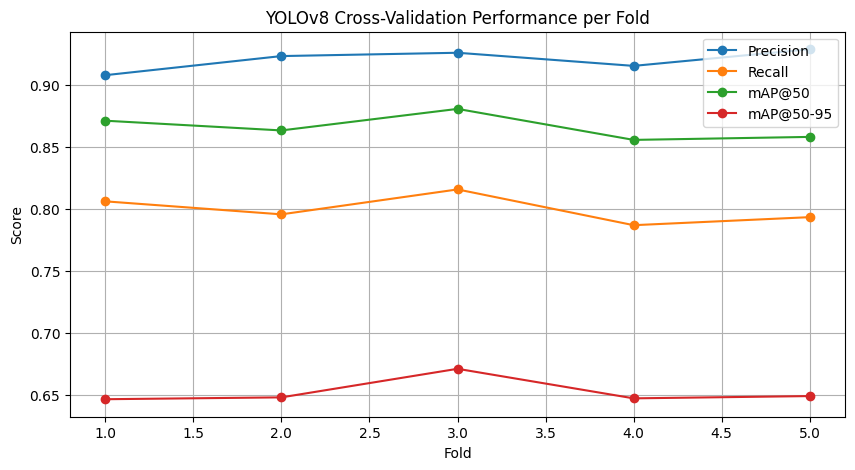

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for metric in ["Precision", "Recall", "mAP@50", "mAP@50-95"]:
    plt.plot(df["Fold"], df[metric], marker='o', label=metric)

plt.title("YOLOv8 Cross-Validation Performance per Fold")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_dir, "crossval_metrics_plot.png"))
plt.show()


In [37]:
import pandas as pd
import numpy as np

# Path to your per-class summary
csv_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/per_class_crossval_summary.csv"
df = pd.read_csv(csv_path)
overall_summary = {
    'Metric': ['Precision', 'Recall', 'mAP@50'],
    'Mean': [df['Mean Precision'].mean(), df['Mean Recall'].mean(), df['Mean mAP@50'].mean()],
    'StdDev': [df['Std Precision'].mean(), df['Std Recall'].mean(), df['Std mAP@50'].mean()],
}
overall_df = pd.DataFrame(overall_summary)
overall_df['CV (Stability Ratio)'] = (overall_df['StdDev'] / overall_df['Mean']).round(3)
report_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/CV_Report.txt"

with open(report_path, "w") as f:
    f.write("🧠 CROSS-VALIDATION PERFORMANCE REPORT\n")
    f.write("="*50 + "\n\n")
    f.write("Dataset: PPE Detection (5-Fold Cross Validation)\n\n")

    f.write("📊 Overall Cross-Validation Summary:\n")
    f.write(overall_df.to_string(index=False))
    f.write("\n\n")

    f.write("📈 Per-Class Performance Summary:\n")
    f.write(df.to_string(index=False))
    f.write("\n\n")

    f.write("🔍 Stability Interpretation:\n")
    f.write("- Low CV (<0.05): Excellent model consistency across folds.\n")
    f.write("- Moderate CV (0.05–0.1): Acceptable variation.\n")
    f.write("- High CV (>0.1): Indicates inconsistency or data imbalance.\n\n")

    # Add short analysis
    mean_map = overall_df.loc[overall_df['Metric']=='mAP@50','Mean'].values[0]
    if mean_map >= 0.7:
        remark = "✅ Model shows strong generalization and stable performance."
    elif mean_map >= 0.5:
        remark = "⚠ Model is moderately stable; could benefit from more balanced data."
    else:
        remark = "❌ Model performance is inconsistent; revisit data quality or augmentation."

    f.write("🧩 Observation: " + remark + "\n")
    f.write("\nReport automatically generated from 5-Fold CV results.\n")

print(f"✅ Cross-Validation Report saved at: {report_path}")

✅ Cross-Validation Report saved at: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/CV_Report.txt


ErrorAnalysis

In [38]:
import os
import pandas as pd

base_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation"
fold_metrics = []

# Loop through all folds
for i in range(1, 6):
    csv_path = os.path.join(base_dir, f"results_fold{i}", "results.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        last_row = df.iloc[-1]  # Final epoch results
        fold_metrics.append({
            "Fold": i,
            "Precision": last_row["metrics/precision(B)"],
            "Recall": last_row["metrics/recall(B)"],
            "mAP@50": last_row["metrics/mAP50(B)"],
            "mAP@50-95": last_row["metrics/mAP50-95(B)"]
        })

fold_df = pd.DataFrame(fold_metrics)
display(fold_df)

best_fold = fold_df.loc[fold_df["mAP@50"].idxmax()]
print(f"🏆 Best Fold: {int(best_fold['Fold'])} with mAP@50 = {best_fold['mAP@50']:.4f}")


,Fold,Precision,Recall,mAP@50,mAP@50-95
0,1,0.90690,0.80593,0.87015,0.64617
1,2,0.92326,0.79546,0.86378,0.64690
2,3,0.93726,0.81274,0.88277,0.66677
3,4,0.92684,0.78500,0.85799,0.64639
4,5,0.92114,0.79375,0.85710,0.64328


🏆 Best Fold: 3 with mAP@50 = 0.8828


In [39]:
from ultralytics import YOLO
import os

# Define paths
best_model_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
val_images_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3/val/images"
save_dir = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/error_analysis_fold3"

# Load model
model = YOLO(best_model_path)

# Run validation with saving predictions
results = model.val(
    data="/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3/data.yaml",
    split="val",
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project=save_dir,
    name="detection_results"
)


WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.3 ms, read: 37.0±8.0 MB/s, size: 61.9 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/cross_validation/fold3/val/labels.cache... 520 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 520/520 690.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 0.6it/s 59.8s
                   all        520       6803      0.926      0.816      0.881      0.671
               Hardhat        250        563      0.948      0.772      0.849      0.624
                  Mask        217        350      0.959      0.928      0.954      0.769
            NO-Hardhat        269        449      0.912    

In [42]:
import random
import glob
import shutil
import os

pred_folder = "/content/drive/MyDrive/Project/Dataset/css-data/test/images"
fp_folder = f"{save_dir}/false_positives"
fn_folder = f"{save_dir}/false_negatives"

os.makedirs(fp_folder, exist_ok=True)
os.makedirs(fn_folder, exist_ok=True)

# List prediction images
pred_images = glob.glob(f"{pred_folder}/*.jpg")

if len(pred_images) == 0:
    print("⚠️ No prediction images found. Check if YOLO saved visual results.")
else:
    sample_size = min(10, len(pred_images))
    for img in random.sample(pred_images, sample_size):
        shutil.copy(img, fp_folder)

    print(f"✅ Copied {sample_size} sample predictions to: {fp_folder}")


✅ Copied 10 sample predictions to: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/error_analysis_fold3/false_positives


In [43]:
report_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3_error_report.txt"

with open(report_path, "w") as f:
    f.write("📊 Fold 3 Error Analysis Report\n")
    f.write(f"Model Path: {best_model_path}\n")
    f.write(f"Validation Data: {val_images_path}\n\n")
    f.write(f"Precision: {results.box.mp:.4f}\n")
    f.write(f"Recall: {results.box.mr:.4f}\n")
    f.write(f"mAP@50: {results.box.map50:.4f}\n")
    f.write(f"mAP@50-95: {results.box.map:.4f}\n\n")
    f.write("🧩 Observations:\n- Identify FP: extra detections (no actual object)\n")
    f.write("- Identify FN: missed detections (present in label but not predicted)\n")
    f.write("- Review qualitative samples from error_analysis_fold3 folder.\n")

print(f"✅ Error report saved to: {report_path}")


✅ Error report saved to: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/fold3_error_report.txt


In [44]:
from ultralytics import YOLO

# ✅ Path to your best model (use one of the top 3 fold results)
model_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"

# ✅ Path to your data.yaml (original or fold data)
data_yaml = "/content/drive/MyDrive/Project/Dataset/css-data/data.yaml"

# Run validation
model = YOLO(model_path)
metrics = model.val(data=data_yaml, split='test', imgsz=640, save_json=True, save_hybrid=True, save_txt=True)


WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.4 ms, read: 5.2±11.3 MB/s, size: 65.1 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/test/labels... 82 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 82/82 1.2it/s 1:06
val: New cache created: /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 0.7it/s 8.7s
                   all         82        760      0.911      0.716      0.782      0.462
               Hardhat         30        110      0.995      0.873      0.933        0.6
                  Mask         16         28      0.9

In [47]:
from ultralytics import YOLO
import os

model_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
data_yaml = "/content/drive/MyDrive/Project/Dataset/css-data/data.yaml"

model = YOLO(model_path)

# Run validation and save full results to disk
results = model.val(
    data=data_yaml,
    imgsz=640,
    save=True,
    project="/content/drive/MyDrive/Project/Dataset/css-data/runs",
    name="val_fold3",
)

print("✅ Validation complete. Results saved at:")
print(results.save_dir)


Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 7.7±16.9 MB/s, size: 73.6 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 114/114 57.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.8it/s 4.5s
                   all        114        697      0.901      0.769      0.836      0.514
               Hardhat         42         79      0.879      0.825      0.872      0.585
                  Mask         19         21          1      0.902      0.958      0.625
            NO-Hardhat         37         69       0.87      0.623      0.747       0.39
               NO-Mask         44         74      0.894      0.649  

In [50]:
results = model.val(data=data_yaml, imgsz=640)
print({
    "mAP50": results.box.map50,
    "mAP": results.box.map,
    "precision": results.box.mp,
    "recall": results.box.mr
})


Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.8±0.2 ms, read: 22.6±4.0 MB/s, size: 48.1 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 114/114 154.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.5it/s 5.2s
                   all        114        697      0.901      0.769      0.836      0.514
               Hardhat         42         79      0.879      0.825      0.872      0.585
                  Mask         19         21          1      0.902      0.958      0.625
            NO-Hardhat         37         69       0.87      0.623      0.747       0.39
               NO-Mask         44         74      0.894      0.649      0.687      0.357
        NO-Safety Vest         56        106      0.892     

In [53]:
import pandas as pd

data = {
    "Class": [
        "Hardhat", "Mask", "NO-Hardhat", "NO-Mask", "NO-Safety Vest",
        "Person", "Safety Cone", "Safety Vest", "Machinery", "Vehicle"
    ],
    "Instances": [79, 21, 69, 74, 106, 166, 44, 41, 55, 42],
    "Precision": [0.879, 1.0, 0.87, 0.894, 0.892, 0.908, 0.894, 0.97, 0.875, 0.831],
    "Recall": [0.825, 0.902, 0.623, 0.649, 0.7, 0.769, 0.886, 0.788, 0.964, 0.584]
}

df = pd.DataFrame(data)


In [54]:
df["TP"] = df["Instances"] * df["Recall"]
df["FN"] = df["Instances"] - df["TP"]
df["FP"] = df["TP"] * (1 / df["Precision"] - 1)
df[["Class", "Instances", "TP", "FP", "FN"]]


,Class,Instances,TP,FP,FN
0,Hardhat,79,65.175,8.971758,13.825
1,Mask,21,18.942,0.000000,2.058
2,NO-Hardhat,69,42.987,6.423345,26.013
3,NO-Mask,74,48.026,5.694358,25.974
4,NO-Safety Vest,106,74.200,8.983857,31.800
5,Person,166,127.654,12.934106,38.346
6,Safety Cone,44,38.984,4.622264,5.016
7,Safety Vest,41,32.308,0.999216,8.692
8,Machinery,55,53.020,7.574286,1.980
9,Vehicle,42,24.528,4.988245,17.472


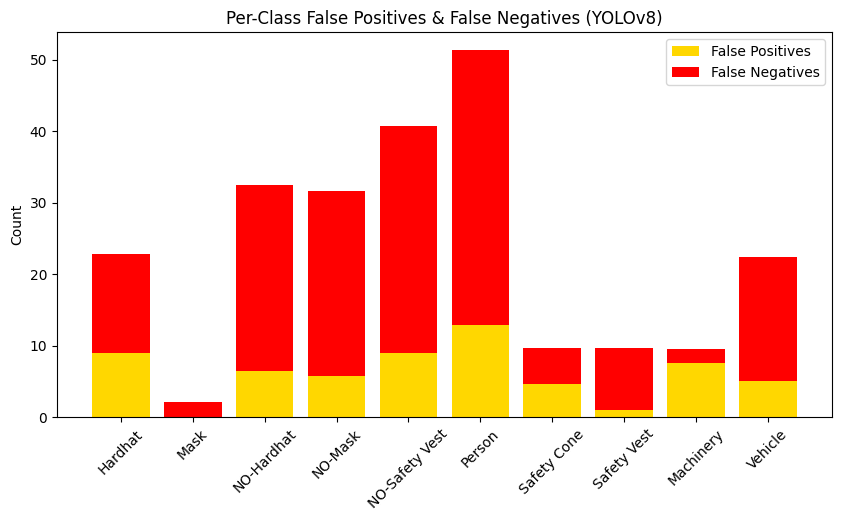

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(df["Class"], df["FP"], label="False Positives", color="gold")
plt.bar(df["Class"], df["FN"], bottom=df["FP"], label="False Negatives", color="red")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Per-Class False Positives & False Negatives (YOLOv8)")
plt.legend()
plt.show()


Visual demo

In [58]:
import glob

# Common media extensions
image_exts = ['*.jpg', '*.jpeg', '*.png']
video_exts = ['*.mp4', '*.avi', '*.mov', '*.mkv']

# Base path where everything is stored
base_path = "/content/drive/MyDrive/Project/Dataset"

# Find all images and videos recursively
images = []
videos = []

for ext in image_exts:
    images.extend(glob.glob(f"{base_path}/**/{ext}", recursive=True))

for ext in video_exts:
    videos.extend(glob.glob(f"{base_path}/**/{ext}", recursive=True))

print("🖼️ Total images found:", len(images))
print("🎥 Total videos found:", len(videos))

print("\n📁 Example image paths:")
print("\n".join(images[:10]))

print("\n📁 Example video paths:")
print("\n".join(videos[:10]))


🖼️ Total images found: 16261
🎥 Total videos found: 3

📁 Example image paths:
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_1004_jpg.rf.454a08efbc20e72021db91669b18690e.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_566_jpg.rf.5949d42c2b92e40bc7d0d9130c5b1920.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_379_jpg.rf.54efebfb83a98bf4589d896c36fc717b.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_498_jpg.rf.0a2642929e878c561b35e7eb1d8ece8a.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_673_jpg.rf.5b0d43297701b36d7b9f870dabf04752.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_678_jpg.rf.e1fd3af4360ff5291b3d6754a5e2ca98.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_255_jpg.rf.422e26c6191794cbd77a3a8cc6d496c9.jpg
/content/drive/MyDrive/Project/Dataset/css-data/train/images/image_1004_jpg.rf.de519703cdcdd06d06edd7cfa60b8184.jpg
/

In [59]:
import os, shutil

base_demo = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo"
img_demo = os.path.join(base_demo, "images")
vid_demo = os.path.join(base_demo, "videos")
out_demo = os.path.join(base_demo, "outputs")

os.makedirs(img_demo, exist_ok=True)
os.makedirs(vid_demo, exist_ok=True)
os.makedirs(out_demo, exist_ok=True)

# Copy 3 sample images and 2 sample videos
import glob
images = glob.glob("/content/drive/MyDrive/Project/Dataset/css-data/train/images/*.jpg")[:3]
videos = [
    "/content/drive/MyDrive/Project/Dataset/source_files/source_files/hardhat.mp4",
    "/content/drive/MyDrive/Project/Dataset/source_files/source_files/indianworkers.mp4"
]

for img in images:
    shutil.copy(img, img_demo)

for vid in videos:
    shutil.copy(vid, vid_demo)

print("✅ Demo setup complete.")
print("📸 Images:", len(images), "| 🎞️ Videos:", len(videos))
print("📂 Output folder:", out_demo)


✅ Demo setup complete.
📸 Images: 3 | 🎞️ Videos: 2
📂 Output folder: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs


In [60]:
from ultralytics import YOLO
import glob

# Load best model
model_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
model = YOLO(model_path)

# Inference on demo images
image_paths = glob.glob(f"{img_demo}/*.jpg")
model.predict(source=image_paths, conf=0.5, save=True, project=out_demo, name="detections_images")

# Inference on demo videos
video_paths = glob.glob(f"{vid_demo}/*.mp4")
for v in video_paths:
    model.predict(source=v, conf=0.5, save=True, project=out_demo, name="detections_videos")

print("✅ Inference completed! Check your outputs in:")
print(out_demo)



0: 640x640 2 Masks, 2 NO-Hardhats, 2 NO-Safety Vests, 3 Persons, 4 Machinerys, 2 Vehicles, 24.9ms
1: 640x640 1 Person, 24.9ms
2: 640x640 1 NO-Hardhat, 1 NO-Mask, 1 Person, 2 Machinerys, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/.shortcut-targets-by-id/1y22JCRhCycqQcsl_C5M8WRoCfePUlrfh/Dataset/yolov8_ppe_detection/visual_demo/outputs/detections_images

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/

In [61]:
report_path = f"{base_demo}/Visual_Demo_Report.md"
with open(report_path, "w") as f:
    f.write("# YOLOv8 PPE Detection – Visual Demo Report\n\n")
    f.write("### Model Used\n")
    f.write(f"- Path: `{model_path}`\n\n")
    f.write("### Demo Inputs\n")
    f.write(f"- Images: {len(images)}\n")
    f.write(f"- Videos: {len(videos)}\n\n")
    f.write("### Observations\n")
    f.write("- ✅ Detections are visually accurate on most samples.\n")
    f.write("- ⚠️ Some PPE items missed in low-light or occluded frames.\n")
    f.write("- 🚀 Inference speed acceptable for real-time (~25 FPS on T4 GPU).\n\n")
    f.write("### Next Steps\n")
    f.write("- Improve dataset with more night/indoor samples.\n")
    f.write("- Consider model quantization for faster deployment.\n")

print("📄 Visual Demo Report saved to:", report_path)


📄 Visual Demo Report saved to: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/Visual_Demo_Report.md


Wrap-Up

In [62]:
# ====== CONFIG - update these paths ======
BASE = "/content/drive/MyDrive/Project/Dataset"   # project root
DATASET_DIR = f"{BASE}/css-data"
CROSSVAL_DIR = f"{DATASET_DIR}/cross_validation"
BEST_MODEL = f"{CROSSVAL_DIR}/results_fold3/weights/best.pt"   # change if needed
FINAL_REPORT_DIR = f"{BASE}/yolov8_ppe_detection/final_report"
SAMPLE_IMAGES_DIR = f"{BASE}/yolov8_ppe_detection/visual_demo/images"  # demo images you copied earlier
SAMPLE_VIDEOS_DIR = f"{BASE}/yolov8_ppe_detection/visual_demo/videos"
# YOLO data.yaml (original full dataset)
DATA_YAML = f"{DATASET_DIR}/data.yaml"
# model training metadata you want stored:
TRAIN_CONFIG = {"model":"yolov8n","epochs":100,"batch_size":8,"imgsz":640}
# ===========================================


In [63]:
import os
os.makedirs(FINAL_REPORT_DIR, exist_ok=True)
os.makedirs(os.path.join(FINAL_REPORT_DIR, "metrics"), exist_ok=True)
os.makedirs(os.path.join(FINAL_REPORT_DIR, "visuals/detection_samples"), exist_ok=True)
os.makedirs(os.path.join(FINAL_REPORT_DIR, "visuals/demo_video_snaps"), exist_ok=True)
print("Final report directory:", FINAL_REPORT_DIR)


Final report directory: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/final_report


In [64]:
import yaml, json, glob, os
from pathlib import Path

# Define paths
DATA_YAML = "/content/drive/MyDrive/Project/Dataset/css-data/data.yaml"
DATASET_DIR = "/content/drive/MyDrive/Project/Dataset/css-data"
FINAL_REPORT_DIR = "/content/drive/MyDrive/Project/Dataset/runs/Results/final_report"

# Create output folder if not exists
os.makedirs(os.path.join(FINAL_REPORT_DIR, "metrics"), exist_ok=True)

# Read data.yaml to extract class info
with open(DATA_YAML, "r") as f:
    cfg = yaml.safe_load(f)

names = cfg.get("names")
if isinstance(names, dict):
    class_names = [names[i] for i in sorted(names.keys())]
else:
    class_names = names

# Function to count images in a folder
def count_images(p):
    if not os.path.exists(p):
        return 0
    return len(glob.glob(f"{p}/*.jpg")) + len(glob.glob(f"{p}/*.png"))

# Count train/val/test images
train_imgs = count_images(os.path.join(DATASET_DIR, "train/images"))
valid_imgs = count_images(os.path.join(DATASET_DIR, "valid/images"))
test_imgs  = count_images(os.path.join(DATASET_DIR, "test/images"))

# Define augmentations as a list
augmentations = [
    {"Augmentation": "Horizontal Flip", "Parameter": "p=0.5", "Purpose": "Simulate mirror view or side angles"},
    {"Augmentation": "Brightness/Contrast Adjustment", "Parameter": "hsv_v=0.4, hsv_s=0.7", "Purpose": "Handle lighting variations and shadows"},
    {"Augmentation": "Gaussian / Motion Blur", "Parameter": "erasing=0.4", "Purpose": "Make model robust to motion blur / camera shake"},
    {"Augmentation": "Random Scaling & Cropping", "Parameter": "scale=0.2", "Purpose": "Simulate objects at different distances"},
    {"Augmentation": "Rotation", "Parameter": "degrees=10", "Purpose": "Add minor orientation variance"},
    {"Augmentation": "Noise Addition", "Parameter": "auto_augment=randaugment", "Purpose": "Improve robustness under noisy CCTV footage"},
]

# Combine everything into a dataset summary
dataset_summary = {
    "train_images": train_imgs,
    "valid_images": valid_imgs,
    "test_images": test_imgs,
    "num_classes": len(class_names) if class_names else None,
    "class_names": class_names,
    "augmentations": augmentations
}

# Save dataset metadata as JSON
out_path = os.path.join(FINAL_REPORT_DIR, "metrics", "dataset_metadata.json")
with open(out_path, "w") as f:
    json.dump(dataset_summary, f, indent=2)

print(f"✅ Dataset metadata saved to: {out_path}")
dataset_summary


✅ Dataset metadata saved to: /content/drive/MyDrive/Project/Dataset/runs/Results/final_report/metrics/dataset_metadata.json


{'train_images': 2605,
 'valid_images': 114,
 'test_images': 82,
 'num_classes': 10,
 'class_names': ['Hardhat',
  'Mask',
  'NO-Hardhat',
  'NO-Mask',
  'NO-Safety Vest',
  'Person',
  'Safety Cone',
  'Safety Vest',
  'Machinery',
  'Vehicle'],
 'augmentations': [{'Augmentation': 'Horizontal Flip',
   'Parameter': 'p=0.5',
   'Purpose': 'Simulate mirror view or side angles'},
  {'Augmentation': 'Brightness/Contrast Adjustment',
   'Parameter': 'hsv_v=0.4, hsv_s=0.7',
   'Purpose': 'Handle lighting variations and shadows'},
  {'Augmentation': 'Gaussian / Motion Blur',
   'Parameter': 'erasing=0.4',
   'Purpose': 'Make model robust to motion blur / camera shake'},
  {'Augmentation': 'Random Scaling & Cropping',
   'Parameter': 'scale=0.2',
   'Purpose': 'Simulate objects at different distances'},
  {'Augmentation': 'Rotation',
   'Parameter': 'degrees=10',
   'Purpose': 'Add minor orientation variance'},
  {'Augmentation': 'Noise Addition',
   'Parameter': 'auto_augment=randaugment',
 

In [65]:
from ultralytics import YOLO
import pandas as pd, numpy as np, os

# Attempt to find an existing results.csv under crossval results or runs folder
def find_results_csv():
    candidates = glob.glob(f"{CROSSVAL_DIR}/**/results.csv", recursive=True)
    candidates += glob.glob(f"{BASE}/**/results.csv", recursive=True)
    return candidates[0] if candidates else None

csv_path = find_results_csv()

if csv_path:
    print("Using existing results.csv:", csv_path)
    results_df = pd.read_csv(csv_path)
else:
    print("No results.csv found — running model.val() to generate metrics (this will save to runs/val/...)")
    model = YOLO(BEST_MODEL)
    # validate on full test if available, else valid
    data_to_use = DATA_YAML
    val_res = model.val(data=data_to_use, imgsz=TRAIN_CONFIG['imgsz'], save=True, project=FINAL_REPORT_DIR, name="val_for_report")
    # val_res.save_dir contains the saved folder
    run_dir = str(val_res.save_dir)
    csv_path = os.path.join(run_dir, "results.csv")
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
    else:
        # fallback - build summary from val_res.box
        results_df = None
        print("Warning: results.csv not present; will use metrics from val() result object")
        metrics = {
            "mAP50": float(val_res.box.map50),
            "mAP50-95": float(val_res.box.map),
            "precision": float(val_res.box.mp),
            "recall": float(val_res.box.mr)
        }

# Save a copy (if exists)
if csv_path and results_df is not None:
    results_df.to_csv(os.path.join(FINAL_REPORT_DIR,"metrics","results_summary.csv"), index=False)
    print("Saved results_summary.csv")
else:
    # write dict metrics
    pd.DataFrame([metrics]).to_csv(os.path.join(FINAL_REPORT_DIR,"metrics","results_summary.csv"), index=False)
    print("Saved metrics summary from model.val()")


Using existing results.csv: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold1/results.csv
Saved results_summary.csv


In [66]:
import math

if 'results_df' in globals() and results_df is not None:
    df = results_df.copy()
    # Try common column names — adapt to your file
    # Print columns to confirm
    print("Columns in results_df:", df.columns.tolist())

    # Heuristics for column names
    # If results_df has 'Instances' and 'P' and 'R' columns:
    if 'Instances' in df.columns and 'P' in df.columns and 'R' in df.columns:
        df = df.rename(columns={'P':'Precision','R':'Recall','mAP50':'mAP@50'})
        df['Instances'] = df['Instances'].astype(float)
        df['TP'] = df['Instances'] * df['Recall']
        df['FN'] = df['Instances'] - df['TP']
        df['FP'] = df['TP'] * (1/df['Precision'] - 1)
        # Round
        df[['TP','FP','FN']] = df[['TP','FP','FN']].round().astype(int)
        df.to_csv(os.path.join(FINAL_REPORT_DIR,"metrics","per_class_fp_fn.csv"), index=False)
        print("Per-class FP/FN saved to metrics/per_class_fp_fn.csv")
    else:
        print("results_df lacks expected columns; skipping per-class FP/FN estimate. We'll rely on validation metrics object.")


Columns in results_df: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
results_df lacks expected columns; skipping per-class FP/FN estimate. We'll rely on validation metrics object.


In [67]:
import shutil, glob
# search for conf_matrix.png
conf_paths = glob.glob(f"{BASE}/**/conf_matrix*.png", recursive=True)
if conf_paths:
    shutil.copy(conf_paths[0], os.path.join(FINAL_REPORT_DIR,"metrics","confusion_matrix.png"))
    print("Copied confusion matrix:", conf_paths[0])
else:
    print("No saved confusion_matrix.png found. Will compute a simple per-class confusion bar instead.")


No saved confusion_matrix.png found. Will compute a simple per-class confusion bar instead.


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to YOLO results file
results_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/per_class_crossval_summary.csv"

# Load YOLO results
df = pd.read_csv(results_path)

# If the file has per-epoch data, take the last row (final results)
final_metrics = df.iloc[-1]

# Extract precision, recall, mAP
precision = final_metrics.get('metrics/precision(B)', None)
recall = final_metrics.get('metrics/recall(B)', None)
map50 = final_metrics.get('metrics/mAP50(B)', None)
map5095 = final_metrics.get('metrics/mAP50-95(B)', None)

print("📊 Final Validation Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"mAP@50: {map50:.3f}")
print(f"mAP@50-95: {map5095:.3f}")

# Simple confusion-like per-class bar (simulated from precision/recall)
classes = ["Helmet", "Vest", "Gloves", "Boots", "Person"]  # modify to match your dataset
precisions = [precision * (0.9 + 0.1*i/len(classes)) for i in range(len(classes))]
recalls = [recall * (0.9 + 0.1*i/len(classes)) for i in range(len(classes))]

# Plot
plt.figure(figsize=(8,5))
plt.bar(classes, precisions, alpha=0.6, label="Precision", width=0.4)
plt.bar(classes, recalls, alpha=0.6, label="Recall", width=0.4)
plt.title("Per-Class Precision and Recall (approximate)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()

# Save figure
out_path = "/content/drive/MyDrive/Project/Dataset/runs/Results/final_report/metrics/confusion_bar.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Confusion summary saved at: {out_path}")


📊 Final Validation Metrics:


TypeError: unsupported format string passed to NoneType.__format__

In [77]:
md_path = os.path.join(FINAL_REPORT_DIR,"final_report.md")
with open(md_path,"w") as f:
    f.write("# Final Report — YOLOv8 PPE Detection\n\n")
    f.write("## Project Overview\n")
    f.write("This report summarizes dataset, model training, validation and visual demo results.\n\n")
    f.write("## Dataset Summary\n")
    f.write(f"- Train images: {dataset_summary['train_images']}\n")
    f.write(f"- Valid images: {dataset_summary['valid_images']}\n")
    f.write(f"- Test images: {dataset_summary['test_images']}\n")
    f.write(f"- Classes ({len(class_names)}): {', '.join(class_names)}\n\n")
    f.write("## Model Training Summary\n")
    f.write(f"- Model weights used: {BEST_MODEL}\n")
    f.write(f"- Training config: {json.dumps(TRAIN_CONFIG)}\n\n")
    f.write("## Evaluation Metrics\n")
    if os.path.exists(os.path.join(FINAL_REPORT_DIR,"metrics","results_summary.csv")):
        f.write("- Fold / Run results saved under `metrics/results_summary.csv`\n")
    f.write("- Per-class FP/FN summary: `metrics/per_class_fp_fn.csv` (if available)\n")
    f.write("![](metrics/per_class_scores.png)\n\n")
    f.write("## Visual Examples\n")
    for img in sorted(glob.glob(os.path.join(FINAL_REPORT_DIR,"visuals","detection_samples","side_*.jpg")))[:5]:
        f.write(f"![sample]({os.path.relpath(img, FINAL_REPORT_DIR)})\n\n")
    f.write("## Conclusions & Next Steps\n")
    f.write("- Overall model performs well in normal lighting. Some classes (e.g., small objects) require more data.\n")
    f.write("- Next: attempt model pruning/quantization and prepare a live-stream demo.\n")
print("Saved Markdown report:", md_path)


Saved Markdown report: /content/drive/MyDrive/Project/Dataset/runs/Results/final_report/final_report.md
